<center><h1><font color=navy> Price Errors Between Invoices and POs</font></h1></center>
<center><h2> Are we systematically overpaying Invoices? </h2></center><br>
<p>
<img src="http://www.ncseprojects.org/files/images/berkeley_logo_300.gif" style="float: left; width: 15%; margin-left: 30%;">

<img src="http://www.ucsf.edu/sites/all/themes/ucsf/logo.png" style="float: right; width: 20%; margin-right: 30%; margin-bottom: 10%;">
<p style="clear: both;">

<center><h1><font color=navy>Contributors:</font></h1></center>
<p>
<center><h2>Andrew G. Clark</h2></center>

<font face="vollkorn" size=3><p><b>Purpose:</b><br>
This book explores the accuracy of pricing invoiced to UCSF and UC Berkeley versus the Purchase Order. 

<p><b>Background:</b> <br>
UCSF issues Purchase Orders (binding legal contracts) to suppliers as a "promise" to pay for goods and services. The PO serves as official notice to the supplier of the goods/services we wish to buy, along with the price we are authorizing for payment, and any other terms and conditions we require.  It is generally expected that the supplier will either fill the purchase order and send UCSF the goods/services ordered or will call UCSF to identify a problem with the order.  
<p>
In Febuary 2015, UCSF BearBuy Operations was notified by a key stakeholder that they belived we were being systematically over-invoiced.  That is to say, suppliers were issuing invoices to UCSF for dollar amounts greater than the PO authorized.  As a result, this was causing a great deal of work for this stakeholder who was carefully reconciling her budgets.

<p><b>Assumptions:</b><br>
+ PO Line Extended Price vs. Invoice Line Extended Price is correct identifier of price error.
+ The invoice full extract from BearBuy(s) is the right dataset to use.
+ BearBuy PO number is a reasonable approximation for time.

<p><b>To Do:</b><br>
+ Check the quantity on the PO vs. quantity invoiced.
+ Check the intersection of Suppliers and Departments.

<font face="vollkorn"><h2>Read in data and pre-process it</h2>
<p><font size=3>The BearBuy Invoice extract includes a number of columns unnecessary for this analysis.  This section of code reads in the data, creates a list of important columns, then removes all columns not on the list.

In [1]:
%pylab inline
import pandas as pd
import numpy as np

#Read in the data
RawData = pd.read_csv('/home/analyst/Desktop/invoices/Berkeley_Invoices.csv', low_memory=False, thousands=',',
                      converters={'Invoice System Created Date': lambda x: pd.to_datetime(x)}
                     )


#The UCSF file has different headers to describe the same data.  Rename UCSF Headers to match UCB Headers.
try:
    RawData.rename(columns={'PO #':'PO No', 
                            'Extended Price1':'Invoice Line Extended Price',
                            'Extended Price2':'PO Line Extended Price',
                            'PO Line #':'PO Line No',
                            'Voucher #':'Voucher No',
                            'Invoice System Creation Date':'Invoice System Created Date',
                            'Home Department Name':'Department Name',
                            'Invoice Type':'Voucher Type'
                           }, inplace=True)
except:
    pass

#Eliminate columns not used in the analysis [uses the Berkeley file name convention]
keep_columns = ['PO No',
                'PO Line No',
                'PO Line Unit Price',
                'PO Line Extended Price',
                'Supplier Name',
                'Manufacturer',
                'Department Name',
                'Invoice Owner',
                'Item Type',
                'Form Type',
                'Voucher No',
                'Voucher Source',
                'Voucher Type',
                'Invoice Line Unit Price',
                'Invoice Line Extended Price',
                'Voucher Status',
                'Workflow Status',
                'Line Status',
                'Invoice System Created Date',
                'Quantity',
                'PO Line Quantity'
               ]

invoices = RawData[keep_columns];

Populating the interactive namespace from numpy and matplotlib


<font face="vollkorn"><h2>Filter the data and add PO features</h2>
<p><font size=3>The dataset contains far more types of documents than "regular" invoices.  As such, some additional filtering is required.  Specifically:
* Filter non-PO data: We eliminate anything not starting with a "B".
* Filter unprocessed invoices: The data includes a host of invoices which have not been approved by campus accounts payable.  These are removed.
* Filter credit memos: We constrain our focus to just invoices and not credit memos or other documents in the data.
* Filter Blanket POs: Blanket POs are PO Lines that are used to pay for multiple invoices.  There is no apriori specified buy when the Blanket is created, rather, these are authorizations for campus officials to spend fixed dollar amounts with a specific supplier.  This typically makes sense when administration wants to frontload all approvals and authorizations to better streamline the buying activity of researchers, faculty, and other staff.  


In [2]:
#filter out all of the non-invoice invoices...
invoices_filtered = invoices[(invoices['PO No'].str.startswith('B')) &
                              (invoices['Invoice Line Extended Price'] > 0) &
                              (invoices['Voucher Type'] != 'Credit Memo') &
                              (invoices['Workflow Status'] == 'Complete') &
                              (invoices['Line Status'] == 'Approved') & 
                              (invoices['Quantity'] == invoices['PO Line Quantity'])]


#Summarize the data by PO Number and calculate some features
summary = invoices_filtered.groupby(['PO No','PO Line No','Supplier Name']).agg({'PO Line Extended Price': lambda x: x.unique(),
                                                                                 'Invoice Line Extended Price': np.sum,
                                                                                 'Voucher No': lambda x: len(x.unique())
                                                                                 })


#Calculate the features of interest
summary['PO Amount Used'] = summary['Invoice Line Extended Price'] / summary['PO Line Extended Price']
summary['PriceDiff'] = summary['Invoice Line Extended Price'] - summary['PO Line Extended Price'] 
summary['PercentDiff'] = summary['PriceDiff'] / summary['PO Line Extended Price']

#Remove the blanket POs by creating a filter
NonBlanket_filter = summary[(summary['Voucher No'] <= 2) &
                      (summary['PO Amount Used'] >= .70) &
                      (summary['PercentDiff'] >= -.40) &
                      (summary['PercentDiff'] <= .40) 
                     ].reset_index()


#Filter the invoices to just the non-blankets
NonBlanket = invoices_filtered[invoices_filtered['PO No'].isin(NonBlanket_filter['PO No'])].copy()

#Add some features
NonBlanket.loc[:,'PriceDiff'] = NonBlanket['Invoice Line Extended Price'] - NonBlanket['PO Line Extended Price']
NonBlanket.loc[:,'PercentDiff'] = NonBlanket['PriceDiff'] / NonBlanket['PO Line Extended Price'];
NonBlanket.loc[:,'IsError'] = NonBlanket['PercentDiff'] != 0

<font face="vollkorn"><h2>What do the price errors look like</h2>
<p><font size=3>No that we are down to a reasonable set of POs and Invoices, we can begin exploring the data to understand key trends and issues.

5.82 percent of Non-Blanket POs contain a price error


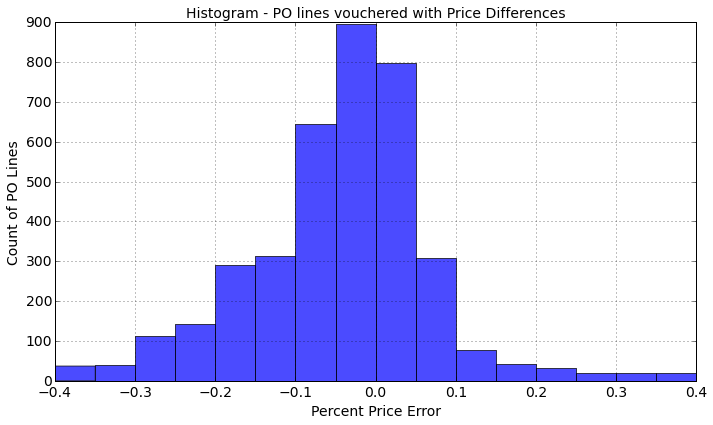

In [3]:
maxbin = .4
minbin = -.4
binwidth = .05

#Plot a Histogram of all of the non-Zero, Non-Blanket PO Lines
NonBlanket[NonBlanket['PercentDiff'] != 0].hist('PercentDiff', bins=np.arange(minbin, maxbin + binwidth, binwidth),
                                                  alpha=.7, figsize=(10,6),histtype='bar',xlabelsize=14, ylabelsize=14)
plt.xlabel('Percent Price Error', fontsize=14);
plt.ylabel('Count of PO Lines', fontsize=14);
plt.title('Histogram - PO lines vouchered with Price Differences', fontsize=14)
plt.tight_layout()

print '%0.2f percent of Non-Blanket POs contain a price error' %round(100*(float(NonBlanket[NonBlanket['PercentDiff'] != 0].count()[1]) / float(NonBlanket.count()[1])),2)


<font face="vollkorn"><p><font size=3>The first notable point is that the mean of the data is negative.  Meaning that we are systematically under-invoiced. We can also see a precipitous drop off on the positive side of the curve, which is likely due to the checks and balances UC has in place to avoid over-payment.

<font face="vollkorn"><h2>Does Ordering Method Matter?</h2>
<p><font size=3>Using the <i>"Item Type"</i> column as a proxy for ordering method.  This field identifies whether the item purchased was in the hosted environment, the punchout environment, a non-catalog form, or a UCSF/B managed contract item.  
<p><font size=3>We can see that NonCatalog forms are generating both a high number of price errors as well as a high error rate.  Secondarily, we see that Contract Non-Catalog Items are generating a higher percent of errors, but as these are rarely used, we see very little in the way of counts.

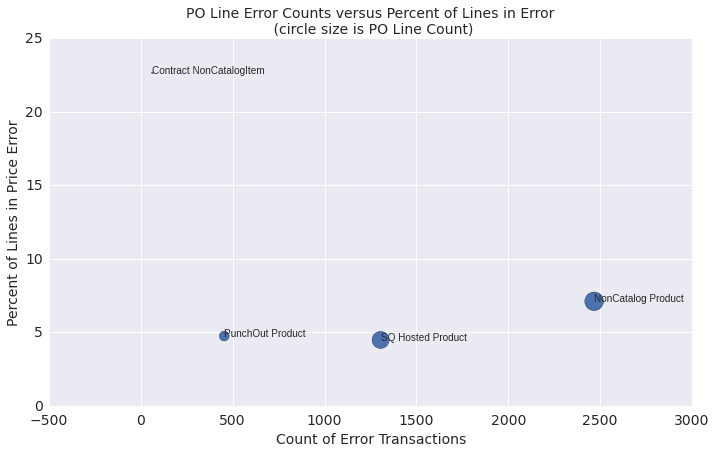

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ItemType = NonBlanket.groupby(['Item Type','IsError']).agg({'IsError':'count'}).unstack()

ItemType.columns = ItemType.columns.droplevel(0)
ItemType = ItemType.reset_index()
ItemType = ItemType.rename(columns = {ItemType.columns[1]:'NotError',
                                      ItemType.columns[2]:'IsError'
                                      })

ItemType['Percent Error'] = ItemType['IsError'] / (ItemType['IsError'] + ItemType['NotError']) * 100


ItemType.plot(kind='scatter', x='IsError', y='Percent Error', s=(ItemType['IsError'] + ItemType['NotError'])/100,
              figsize=(10,6), fontsize=14)
plt.tight_layout()
plt.xlabel('Count of Error Transactions', fontsize=14);
plt.ylabel('Percent of Lines in Price Error', fontsize=14);
plt.title('PO Line Error Counts versus Percent of Lines in Error \n (circle size is PO Line Count)', fontsize=14)


#Annotate Each Point
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(ItemType['IsError'], ItemType['Percent Error'], ItemType['Item Type'], plt)


<font face="vollkorn"><h2>Within Each Category, who are the top offenders by count?</h2>
<p><font size=3>We already discovered that non-catalog orders have the highest number and percent of match exceptions.  However, are there any trends from the suppliers across the 4 different order methods?
<p><font size=3>

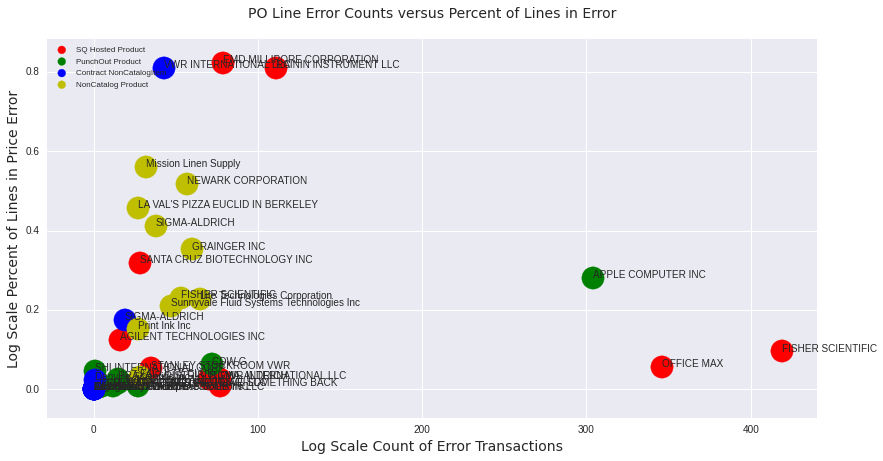

In [5]:
#Group By Supplier and ItemType, counting each line
SupplierSummary = NonBlanket.groupby(['Supplier Name','Item Type','IsError']).agg({'PO Line No':'count'}
                                                                                 ).unstack()



SupplierSummary.columns = SupplierSummary.columns.droplevel(0)
SupplierSummary = SupplierSummary.reset_index()
SupplierSummary = SupplierSummary.fillna(0) 
SupplierSummary = SupplierSummary.rename(columns = {SupplierSummary.columns[2]:'NotError',
                                                    SupplierSummary.columns[3]:'IsError'
                                                    })
tmp = []
listsize = 10
for itemtype in SupplierSummary['Item Type'].unique():
    if len(tmp) == 0:
        tmp = SupplierSummary[SupplierSummary['Item Type'] == itemtype].sort('IsError', ascending=False).head(listsize)
    else:
        tmp = tmp.append(SupplierSummary[SupplierSummary['Item Type'] == itemtype].sort('IsError', ascending=False).head(listsize),
                   ignore_index=True)

#Make a cool heamap showing the supplier name and category names
tmpPivot = tmp.pivot_table(index=['Supplier Name','Item Type'], aggfunc=np.sum).reset_index()
tmpPivot['ErrorRate'] = tmpPivot.IsError / (tmpPivot.IsError + tmpPivot.NotError)
tmpPivot['totalLines'] = tmpPivot.IsError + tmpPivot.NotError
tmpPivot = tmpPivot.fillna(0)

#Create a bubble chart showing the most egredious supplier item-types
#Create the figure
colors = {1:'r',2:'g',3:'b',4:'y'}

fig,ax = plt.subplots(figsize=(11.5,6))
ax.margins(0.05)
x=0
for itemtype in tmpPivot['Item Type'].unique():
    x += 1
    tmpPivot[(tmpPivot['Item Type']==itemtype)].plot(kind='scatter', x='IsError',y='ErrorRate',
                                                        ax=ax, s=500,
                                                        color=colors[x], label=itemtype, marker='o')



#for i in tmpPivot['Item Type'].unique():
#    ax.plot(tmpPivot[tmpPivot['Item Type'] == i].IsError, tmpPivot[tmpPivot['Item Type'] == i].ErrorRate,
#            linestyle='',ms=12, label=i,marker='o')
ax.legend(tmpPivot['Item Type'].unique(),loc='upper left',fontsize=8, markerscale=.35)   
plt.tight_layout()
plt.xlabel('Log Scale Count of Error Transactions', fontsize=14);
plt.ylabel('Log Scale Percent of Lines in Price Error', fontsize=14);
plt.title('PO Line Error Counts versus Percent of Lines in Error \n', fontsize=14)
#plt.xlabel('test',fontsize=14)

label_point(tmpPivot['IsError'], tmpPivot['ErrorRate'], tmpPivot['Supplier Name'], ax)


<font face="vollkorn"><h2>Which form is causing us grief</h2>
<p><font size=3>

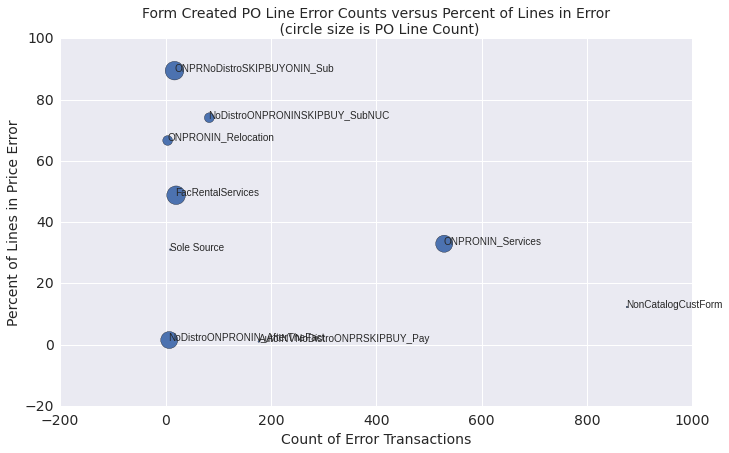

In [6]:
FormType = NonBlanket.groupby(['Form Type','IsError']).agg({'IsError':'count'}).unstack()

FormType.columns = FormType.columns.droplevel(0)
FormType = FormType.reset_index()
FormType = FormType.rename(columns = {FormType.columns[1]:'NotError',
                                      FormType.columns[2]:'IsError'
                                      })

FormType['Percent Error'] = FormType['IsError'] / (FormType['IsError'] + FormType['NotError']) * 100
FormType = FormType.fillna(0)

FormType.plot(kind='scatter', x='IsError', y='Percent Error', s=(ItemType['IsError'] + ItemType['NotError'])/100,
              figsize=(10,6), fontsize=14);
plt.tight_layout()
plt.xlabel('Count of Error Transactions', fontsize=14);
plt.ylabel('Percent of Lines in Price Error', fontsize=14);
plt.title('Form Created PO Line Error Counts versus Percent of Lines in Error \n (circle size is PO Line Count)', fontsize=14)

label_point(FormType['IsError'], FormType['Percent Error'], FormType['Form Type'], plt)